# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Reading the data set

In [2]:
df = pd.read_csv('fraudTrain.csv')
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495.0,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1.325376e+09,36.011293,-82.048315,0.0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149.0,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1.325376e+09,49.159047,-118.186462,0.0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154.0,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1.325376e+09,43.150704,-112.154481,0.0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939.0,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1.325376e+09,47.034331,-112.561071,0.0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99.0,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1.325376e+09,38.674999,-78.632459,0.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62256 entries, 0 to 62255
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             62256 non-null  int64  
 1   trans_date_trans_time  62256 non-null  object 
 2   cc_num                 62256 non-null  int64  
 3   merchant               62256 non-null  object 
 4   category               62256 non-null  object 
 5   amt                    62256 non-null  float64
 6   first                  62256 non-null  object 
 7   last                   62256 non-null  object 
 8   gender                 62256 non-null  object 
 9   street                 62256 non-null  object 
 10  city                   62256 non-null  object 
 11  state                  62256 non-null  object 
 12  zip                    62256 non-null  int64  
 13  lat                    62256 non-null  float64
 14  long                   62256 non-null  float64
 15  ci

In [3]:
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)


In [ ]:
df['is_fraud'].value_counts()

is_fraud
0.0    539409
1.0      3210
Name: count, dtype: int64

<ipython-input-22-d09ca3df07e1>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='is_fraud', palette='viridis')


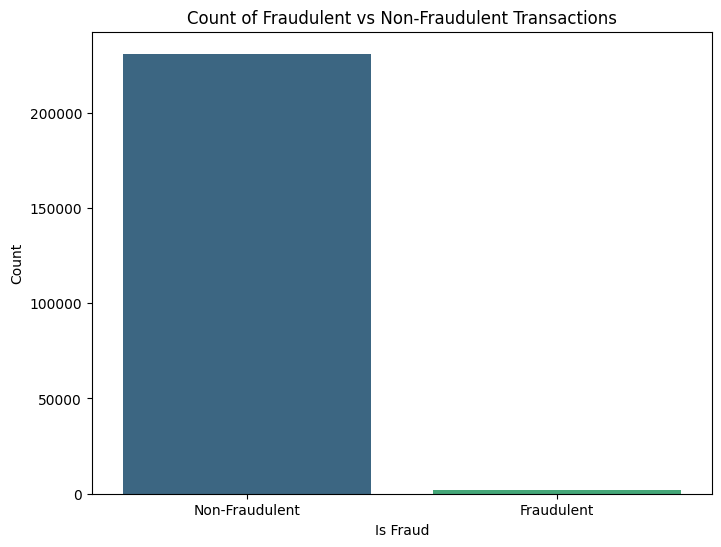

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='is_fraud', palette='viridis')
plt.title('Count of Fraudulent vs Non-Fraudulent Transactions')
plt.xlabel('Is Fraud')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Non-Fraudulent', 'Fraudulent'])
plt.show()

We can notice that the data is highly imbalanced.

In [4]:
df[df['is_fraud'] == 1]['amt'].mean()


526.3368348623853

In [5]:
df[df['is_fraud'] == 0]['amt'].mean()

67.61534430476782

Preprocessing

In [6]:
# Convert 'trans_date_trans_time' to datetime
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

# Extract additional features from 'trans_date_trans_time'
df['hour'] = df['trans_date_trans_time'].dt.hour
df['day'] = df['trans_date_trans_time'].dt.day
df['month'] = df['trans_date_trans_time'].dt.month
df['year'] = df['trans_date_trans_time'].dt.year

# Select features
features = ['amt', 'hour', 'day', 'month', 'year', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long']
X = df[features]
y = df['is_fraud']

In [7]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Used SMOTE to treat highly imbalanced data

In [ ]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [ ]:
# Train a Random Forest classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_smote, y_train_smote)

# Make predictions
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

# Evaluate the model
print("Train Set Evaluation:")
print(classification_report(y_train, y_pred_train))
print("Test Set Evaluation:")
print(classification_report(y_test, y_pred_test))

# Calculate AUC-ROC for the test data
test_roc_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
print(f"Test AUC-ROC: {test_roc_auc:.4f}")


Train Set Evaluation:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1031354
           1       1.00      1.00      1.00      5986

    accuracy                           1.00   1037340
   macro avg       1.00      1.00      1.00   1037340
weighted avg       1.00      1.00      1.00   1037340

Confusion Matrix:
[[1031354       0]
 [      0    5986]]
Test Set Evaluation:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257815
           1       0.63      0.64      0.64      1520

    accuracy                           1.00    259335
   macro avg       0.81      0.82      0.82    259335
weighted avg       1.00      1.00      1.00    259335

Confusion Matrix:
[[257242    573]
 [   544    976]]
Test AUC-ROC: 0.9796


Result with SMOTE sampling is good.

In [ ]:
y_train.value_counts()

is_fraud
0.0    973092
1.0      5700
Name: count, dtype: int64

In [ ]:
y_test.value_counts()

is_fraud
0.0    243298
1.0      1400
Name: count, dtype: int64

Other possible Models without sampling

In [8]:
# Train a Logistric Regression model with balanced class weights
lr = LogisticRegression(class_weight='balanced', random_state=42)
lr.fit(X_train, y_train)

# Make predictions
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

# Evaluate the model
print("Training Set Evaluation:")
print(classification_report(y_train, y_pred_train))

print("Test Set Evaluation:")
print(classification_report(y_test, y_pred_test))

# Calculate AUC-ROC
train_roc_auc = roc_auc_score(y_train, lr.predict_proba(X_train)[:, 1])
test_roc_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1])

print(f"Training AUC-ROC: {train_roc_auc:.4f}")
print(f"Test AUC-ROC: {test_roc_auc:.4f}")

Training Set Evaluation:
              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97    659537
         1.0       0.08      0.74      0.15      3855

    accuracy                           0.95    663392
   macro avg       0.54      0.85      0.56    663392
weighted avg       0.99      0.95      0.97    663392

Test Set Evaluation:
              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97    164907
         1.0       0.08      0.74      0.14       941

    accuracy                           0.95    165848
   macro avg       0.54      0.85      0.56    165848
weighted avg       0.99      0.95      0.97    165848

Training AUC-ROC: 0.8456
Test AUC-ROC: 0.8501


LR gives very low accuracy to detect fraud.

In [9]:
from sklearn.tree import DecisionTreeClassifier


# Train a Decision Tree model with balanced class weights
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Make predictions
y_pred_train = dt.predict(X_train)
y_pred_test = dt.predict(X_test)

# Evaluate the model
print("Training Set Evaluation:")
print(classification_report(y_train, y_pred_train))

print("Test Set Evaluation:")
print(classification_report(y_test, y_pred_test))

# Calculate AUC-ROC
train_roc_auc = roc_auc_score(y_train, dt.predict_proba(X_train)[:, 1])
test_roc_auc = roc_auc_score(y_test, dt.predict_proba(X_test)[:, 1])

print(f"Training AUC-ROC: {train_roc_auc:.4f}")
print(f"Test AUC-ROC: {test_roc_auc:.4f}")

Training Set Evaluation:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    659537
         1.0       1.00      1.00      1.00      3855

    accuracy                           1.00    663392
   macro avg       1.00      1.00      1.00    663392
weighted avg       1.00      1.00      1.00    663392

Test Set Evaluation:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    164907
         1.0       0.49      0.53      0.51       941

    accuracy                           0.99    165848
   macro avg       0.74      0.76      0.75    165848
weighted avg       0.99      0.99      0.99    165848

Training AUC-ROC: 1.0000
Test AUC-ROC: 0.7630


In [10]:
# Train a Random Forest model with balanced class weights
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

# Make predictions
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

# Evaluate the model
print("Training Set Evaluation:")
print(classification_report(y_train, y_pred_train))

print("Test Set Evaluation:")
print(classification_report(y_test, y_pred_test))

# Calculate AUC-ROC
train_roc_auc = roc_auc_score(y_train, rf.predict_proba(X_train)[:, 1])
test_roc_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])

print(f"Training AUC-ROC: {train_roc_auc:.4f}")
print(f"Test AUC-ROC: {test_roc_auc:.4f}")

Training Set Evaluation:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    659537
         1.0       1.00      1.00      1.00      3855

    accuracy                           1.00    663392
   macro avg       1.00      1.00      1.00    663392
weighted avg       1.00      1.00      1.00    663392

Test Set Evaluation:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    164907
         1.0       0.89      0.50      0.64       941

    accuracy                           1.00    165848
   macro avg       0.94      0.75      0.82    165848
weighted avg       1.00      1.00      1.00    165848

Training AUC-ROC: 1.0000
Test AUC-ROC: 0.9594


Random Forest gives the better accuracy comparatively.

In [11]:
df_test = pd.read_csv('fraudTest.csv')

In [17]:
df_test.drop_duplicates(inplace=True)
df_test.dropna(inplace=True)


In [18]:
df_test['trans_date_trans_time'] = pd.to_datetime(df_test['trans_date_trans_time'])

# Extract additional features from 'trans_date_trans_time'
df_test['hour'] = df_test['trans_date_trans_time'].dt.hour
df_test['day'] = df_test['trans_date_trans_time'].dt.day
df_test['month'] = df_test['trans_date_trans_time'].dt.month
df_test['year'] = df_test['trans_date_trans_time'].dt.year

# Select features
features = ['amt', 'hour', 'day', 'month', 'year', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long']

In [19]:
X_train = df[features]
y_train = df['is_fraud']
X_test = df_test[features]
y_test = df_test['is_fraud']

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Apply the model on test dataset

In [20]:

# Train a Random Forest model with balanced class weights
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

# Make predictions
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

# Evaluate the model
print("Training Set Evaluation:")
print(classification_report(y_train, y_pred_train))

print("Test Set Evaluation:")
print(classification_report(y_test, y_pred_test))

# Calculate AUC-ROC
train_roc_auc = roc_auc_score(y_train, rf.predict_proba(X_train)[:, 1])
test_roc_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])

print(f"Training AUC-ROC: {train_roc_auc:.4f}")
print(f"Test AUC-ROC: {test_roc_auc:.4f}")

Training Set Evaluation:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    824444
         1.0       1.00      1.00      1.00      4796

    accuracy                           1.00    829240
   macro avg       1.00      1.00      1.00    829240
weighted avg       1.00      1.00      1.00    829240

Test Set Evaluation:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     81353
         1.0       0.78      0.25      0.38       306

    accuracy                           1.00     81659
   macro avg       0.89      0.62      0.69     81659
weighted avg       1.00      1.00      1.00     81659

Training AUC-ROC: 1.0000
Test AUC-ROC: 0.9004
